## Model Selection Regression

## Import libraries

In [1]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle


## Load data

In [2]:
with open('pca_data.pkl', 'rb') as f:
    pca_data = pickle.load(f)

X_raw = pca_data['X_raw']
y = pca_data['y']

## Select models to train

In [3]:
available_models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR()
}

# User input: Specify models to use
selected_models = ["LinearRegression", "RandomForest", "Ridge", "Lasso", "GradientBoosting", "SVR"]

# User input: Specify whether to use PCA
use_pca = False  # Set to False to skip PCA
n_components = 5  # Number of principal components to use if PCA is applied

## Training

In [4]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}
best_model = None
best_mean_mse = float("inf")

# Train each selected model
for model_name in tqdm(selected_models, desc="Training Models"):
    if model_name not in available_models:
        print(f"Model {model_name} is not available.")
        continue

    # Initialize model
    model = available_models[model_name]

    # Define pipeline components
    steps = []
    steps.append(("scaler", StandardScaler()))
    if use_pca:
        steps.append(("pca", PCA(n_components=n_components)))
    steps.append(("regressor", model))

    # Create pipeline
    pipeline = Pipeline(steps)

    # Perform CV
    print(f"\nTraining {model_name} with 5-fold Cross-Validation (PCA: {use_pca}, Components: {n_components}):")
    cv_scores = -cross_val_score(pipeline, X_raw, y, cv=cv, scoring='neg_mean_squared_error')

    # Store results
    mean_mse = np.mean(cv_scores)
    std_mse = np.std(cv_scores)
    cv_results[model_name] = {
        "mean_mse": mean_mse,
        "std_mse": std_mse,
        "pipeline": pipeline
    }

    # Check if this model is the best so far
    if mean_mse < best_mean_mse:
        best_mean_mse = mean_mse
        best_model = pipeline

    # Display results for the current model
    print(f"\n{model_name} Cross-Validation Results:")
    print(f"Mean MSE: {mean_mse:.2f}")
    print(f"Standard Deviation of MSE: {std_mse:.2f}")
    print("_" * 100)

Training Models:   0%|          | 0/6 [00:00<?, ?it/s]


Training LinearRegression with 5-fold Cross-Validation (PCA: False, Components: 5):

LinearRegression Cross-Validation Results:
Mean MSE: 3015.38
Standard Deviation of MSE: 291.24
____________________________________________________________________________________________________

Training RandomForest with 5-fold Cross-Validation (PCA: False, Components: 5):


Training Models:  67%|██████▋   | 4/6 [00:01<00:00,  2.49it/s]


RandomForest Cross-Validation Results:
Mean MSE: 3318.58
Standard Deviation of MSE: 341.86
____________________________________________________________________________________________________

Training Ridge with 5-fold Cross-Validation (PCA: False, Components: 5):

Ridge Cross-Validation Results:
Mean MSE: 3012.58
Standard Deviation of MSE: 282.58
____________________________________________________________________________________________________

Training Lasso with 5-fold Cross-Validation (PCA: False, Components: 5):

Lasso Cross-Validation Results:
Mean MSE: 3009.72
Standard Deviation of MSE: 279.88
____________________________________________________________________________________________________

Training GradientBoosting with 5-fold Cross-Validation (PCA: False, Components: 5):


Training Models: 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


GradientBoosting Cross-Validation Results:
Mean MSE: 3412.47
Standard Deviation of MSE: 397.36
____________________________________________________________________________________________________

Training SVR with 5-fold Cross-Validation (PCA: False, Components: 5):

SVR Cross-Validation Results:
Mean MSE: 4989.59
Standard Deviation of MSE: 544.09
____________________________________________________________________________________________________


## Save best model

In [5]:
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"\nBest Model: {best_model.named_steps['regressor'].__class__.__name__}")
print(f"Best Model Mean MSE: {best_mean_mse:.2f}")


Best Model: Lasso
Best Model Mean MSE: 3009.72


## Cross-validation results

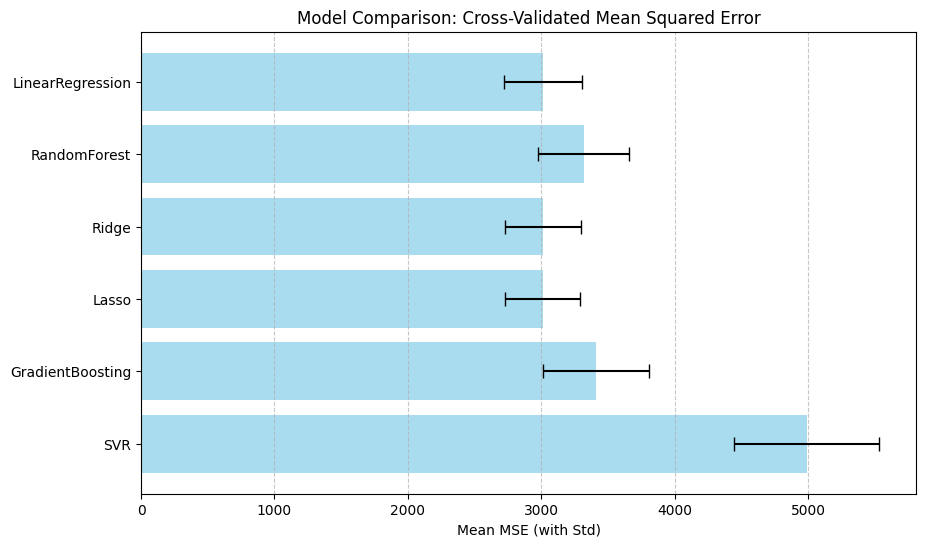

In [6]:
def plot_cv_results(cv_results):
    model_names = []
    mean_mse = []
    std_mse = []

    for model_name, result in cv_results.items():
        model_names.append(model_name)
        mean_mse.append(result["mean_mse"])
        std_mse.append(result["std_mse"])

    plt.figure(figsize=(10, 6))
    plt.barh(model_names, mean_mse, xerr=std_mse, alpha=0.7, color='skyblue', capsize=5)
    plt.xlabel('Mean MSE (with Std)')
    plt.title('Model Comparison: Cross-Validated Mean Squared Error')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

plot_cv_results(cv_results)